In [19]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import IPython.display as display
from PIL import Image
import numpy as np
import tensorflow as tf
%matplotlib inline

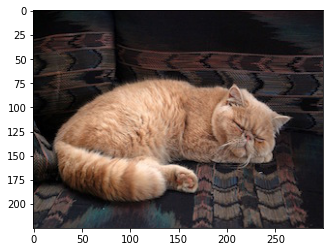

In [28]:
content_image = Image.open("images/persian_cat_content.jpg")
content_image = np.array(content_image)
IMAGE_ROW,IMAGE_HEIGHT,_ = content_image.shape
content_image = np.reshape(content_image, ((1,) + content_image.shape))

imshow(content_image[0])

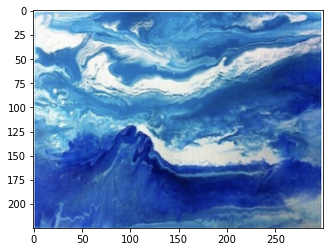

In [34]:
style_image = Image.open("images/water.jpg")
style_image = style_image.resize((IMAGE_HEIGHT,IMAGE_ROW), resample=Image.LANCZOS)

style_image = np.array(style_image)[:,:,:3]

style_image = np.reshape(style_image, ((1,) + style_image.shape))


imshow(style_image[0])


In [35]:

def compute_content_cost(a_C, a_G):
    """
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    """
    m, n_H, n_W, n_C =  a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C,[-1])
    a_G_unrolled = tf.reshape(a_G,[-1])
    
    # compute the cost with tensorflow
    J_content = float(1/(4*n_H*n_W *n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))

    return J_content



$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$



In [36]:

def compute_layer_style_cost(a_S, a_G):
    """
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape=[n_H*n_W , n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[n_H*n_W , n_C]))
    # Computing gram_matrices for both images S and G
    GS = tf.matmul(a_S, tf.transpose(a_S))
    GG = tf.matmul(a_G, tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer = float(1/((2*n_H*n_W*n_C)**2)) * tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    return J_style_layer

In [37]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]  #weights for each layer

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [38]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [39]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    J -- total cost as defined by the formula above.
    """
    J = (alpha * J_content) + (beta * J_style)    
    return J

In [40]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


#### Style image
Let's load, reshape and normalize our "style" image (Claude Monet's painting):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


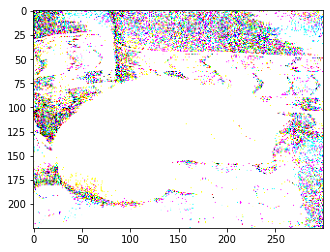

In [41]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);


#### Load pre-trained VGG19 model
Next, as explained in part (2), let's load the VGG19 model.

In [42]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [49]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

#### Style cost

In [50]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [51]:
J = total_cost(J_content,J_style,10,40)


In [52]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step
train_step = optimizer.minimize(J)

In [53]:
def model_nn(sess, input_image, num_iterations = 400):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model
    sess.run(model['input'].assign(input_image))
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%10 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 58682090000.0
content cost = 8928.99
style cost = 1467050000.0
Iteration 10 :
total cost = 36150390000.0
content cost = 21603.682
style cost = 903754400.0
Iteration 20 :
total cost = 24762296000.0
content cost = 29866.904
style cost = 619049900.0
Iteration 30 :
total cost = 18970493000.0
content cost = 34465.758
style cost = 474253700.0
Iteration 40 :
total cost = 14649076000.0
content cost = 36731.64
style cost = 366217700.0
Iteration 50 :
total cost = 11425330000.0
content cost = 38793.81
style cost = 285623550.0
Iteration 60 :
total cost = 9020866000.0
content cost = 40540.406
style cost = 225511500.0
Iteration 70 :
total cost = 7221768700.0
content cost = 41646.91
style cost = 180533810.0
Iteration 80 :
total cost = 5912047600.0
content cost = 42345.332
style cost = 147790610.0
Iteration 90 :
total cost = 4956143600.0
content cost = 42720.56
style cost = 123892920.0
Iteration 100 :
total cost = 4243184400.0
content cost = 42957.156
style cost = 106068870.